In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install pylatexenc
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai
# %pip install qiskit
# %pip install qiskit_machine_learning==0.8.1
# %pip install transformers
# %pip install qiskit_algorithms

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import cv2
from PIL import Image
import torchvision.transforms as transforms
from joblib import Parallel, delayed
import kagglehub
from monai.transforms import ScaleIntensity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.decomposition import PCA
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit

import warnings
warnings.filterwarnings("ignore")

Download latest version https://www.kaggle.com/datasets/nih-chest-xrays/data
(42 GB !!!!)

In [3]:
dataset_root = kagglehub.dataset_download("nih-chest-xrays/data")
path = dataset_root
image_dirs = [os.path.join(path, f"images_{str(i).zfill(3)}") for i in range(1, 13)
              if os.path.exists(os.path.join(path, f"images_{str(i).zfill(3)}"))]

valid_exts = ('.jpg', '.jpeg', '.png')
all_existing_filenames = set()

for d in image_dirs:
    subdir = os.path.join(d, "images")
    if os.path.exists(subdir):
        all_existing_filenames.update(
            f.strip() for f in os.listdir(subdir) if f.lower().endswith(valid_exts)
        )

class_names = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass", "Nodule",
    "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

samples_per_class = 500
meta_df = pd.read_csv(os.path.join(path, "Data_Entry_2017.csv"))
meta_df = meta_df[meta_df['Finding Labels'].notna()]
meta_df['Finding Labels'] = meta_df['Finding Labels'].str.split('|')
meta_df = meta_df[meta_df['Finding Labels'].apply(lambda x: len(x) == 1 and x[0] in class_names)]
meta_df['Label'] = meta_df['Finding Labels'].str[0]

label_encoder = LabelEncoder()
label_encoder.fit(class_names)
meta_df['EncodedLabel'] = label_encoder.transform(meta_df['Label'])

balanced_df = meta_df.groupby('EncodedLabel', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_class), random_state=42)
).reset_index(drop=True)
balanced_df = balanced_df[balanced_df['Image Index'].isin(all_existing_filenames)]

Check data

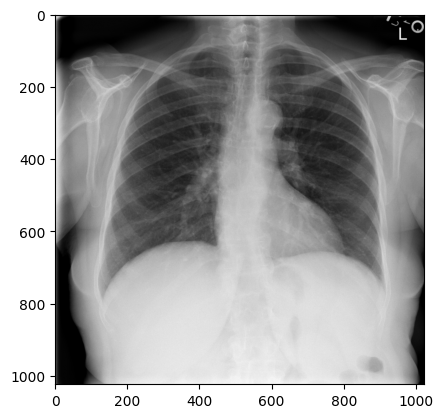

In [5]:
chest_image = cv2.imread(f'{image_dirs[0]}/images/00000047_002.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(chest_image, cmap='gray')

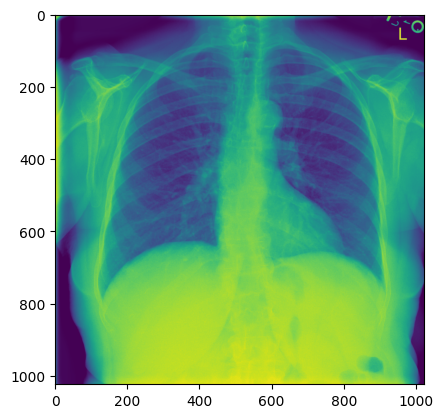

In [6]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
chest_image_scaled = transform_img(chest_image)
colored_kid = cm.viridis(chest_image_scaled)
plt.imshow(colored_kid)

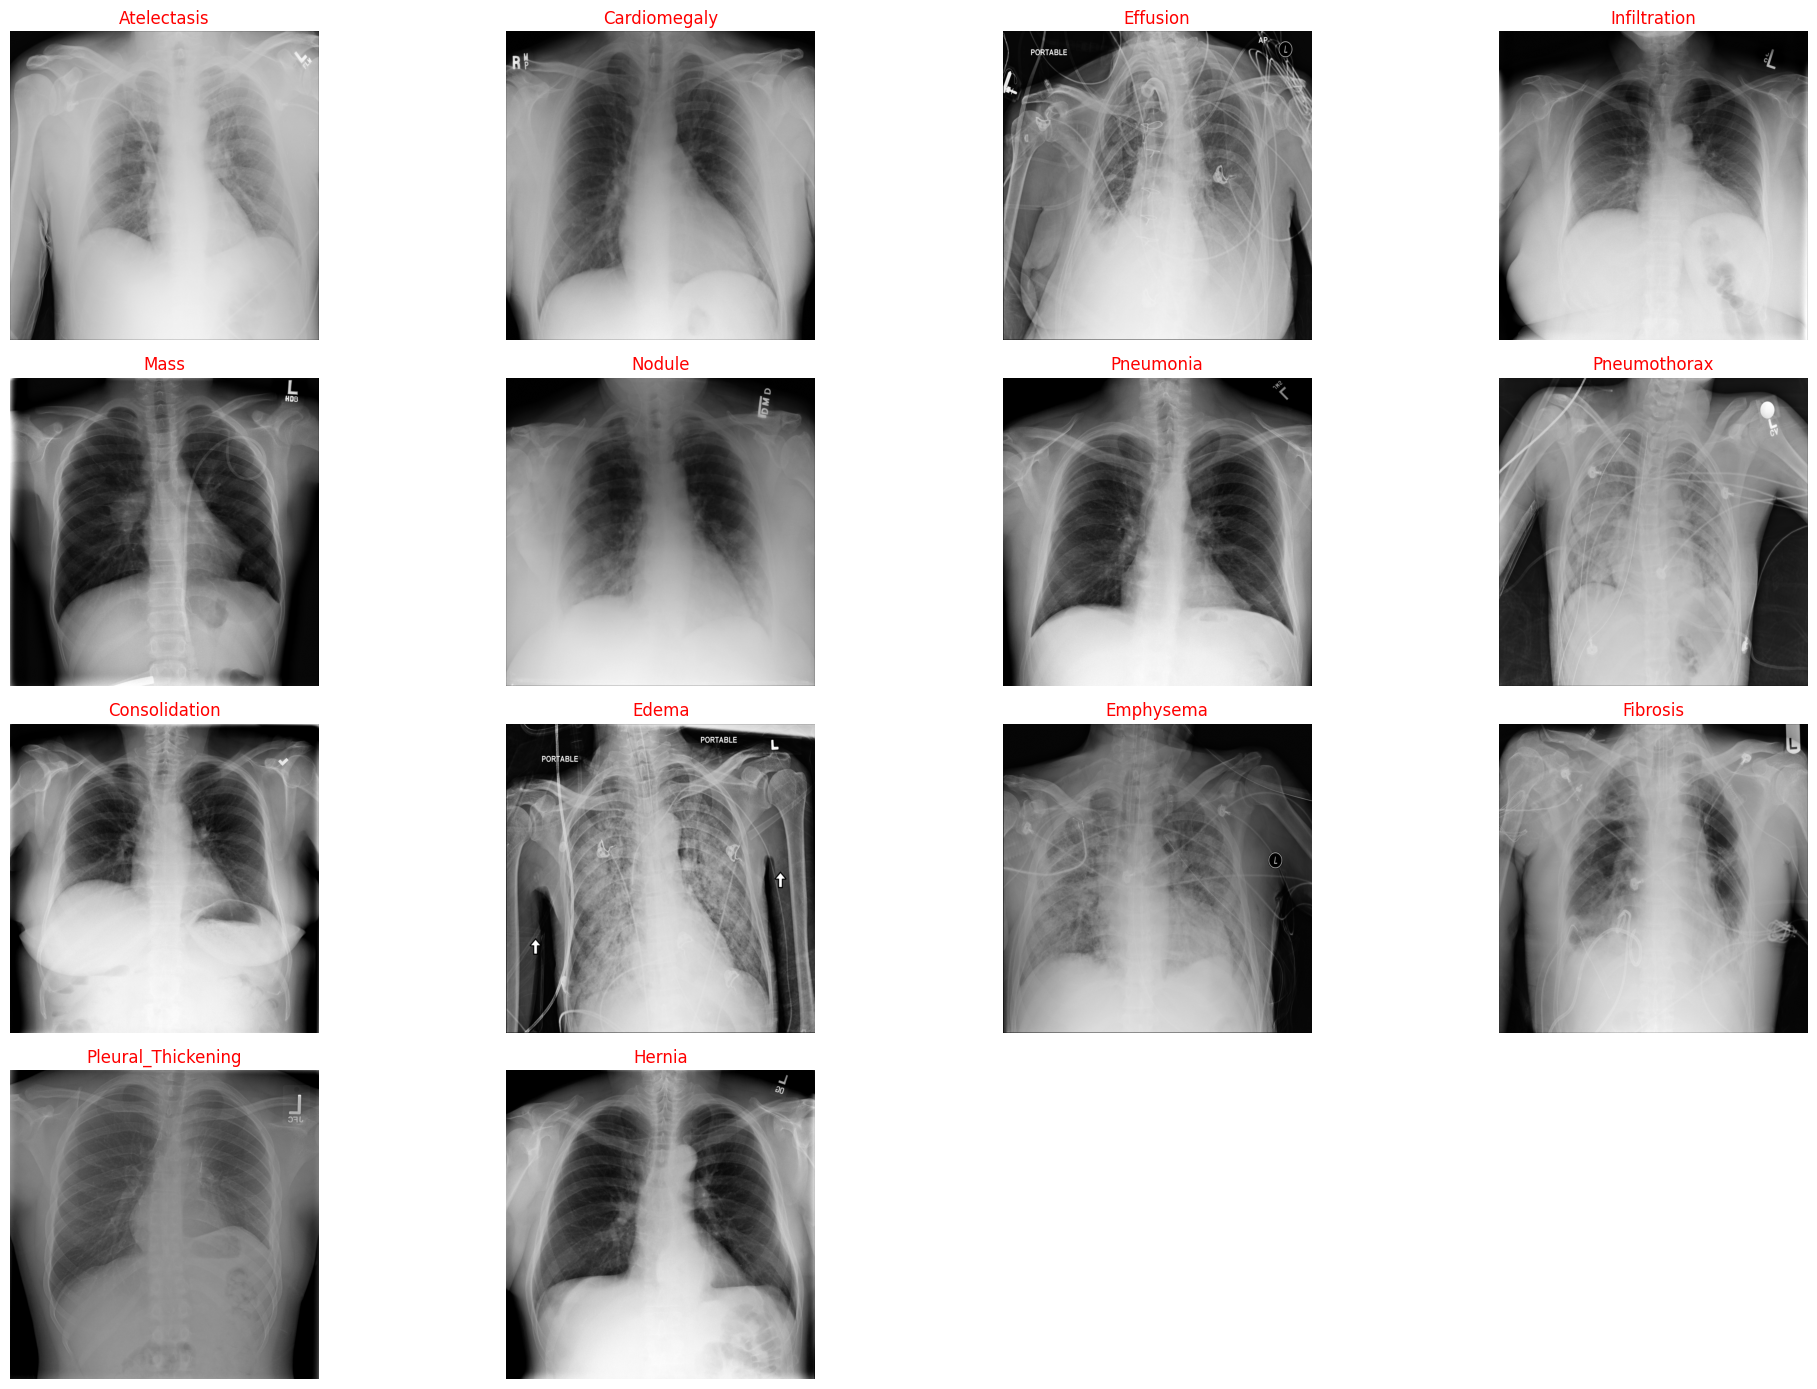

In [7]:
image_index_path_map = {}
for image_dir in image_dirs:
    subdir = os.path.join(image_dir, "images")
    if not os.path.exists(subdir):
        continue
    for fname in os.listdir(subdir):
        if fname.lower().endswith(valid_exts):
            image_index_path_map[fname] = os.path.join(subdir, fname)

sample_images = []
for class_name in class_names:
    row = balanced_df[balanced_df['Label'] == class_name].iloc[0]
    filename = row['Image Index']
    label = row['Label']
    full_path = image_index_path_map.get(filename)
    if full_path and os.path.exists(full_path):
        sample_images.append((full_path, label))

plt.figure(figsize=(20, 14))
for i, (img_path, label) in enumerate(sample_images):
    plt.subplot(4, 4, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=12, color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

IMAGE LOADING

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def load_image(file_name):
    for d in image_dirs:
        image_path = os.path.join(d, "images", file_name)
        if os.path.exists(image_path):
            img = Image.open(image_path).convert("L")  # grayscale
            return transform(img).flatten().numpy()
    return None

image_features = []
valid_indices = []

for idx, row in balanced_df.iterrows():
    features = load_image(row['Image Index'])
    if features is not None:
        image_features.append(features)
        valid_indices.append(idx)

balanced_df = balanced_df.iloc[valid_indices].reset_index(drop=True)
X_all = np.array(image_features)
y_all = balanced_df['EncodedLabel'].values

DIMENSION REDUCTION

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

pca = PCA(n_components=6)  # Match num_qubits
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Class distribution

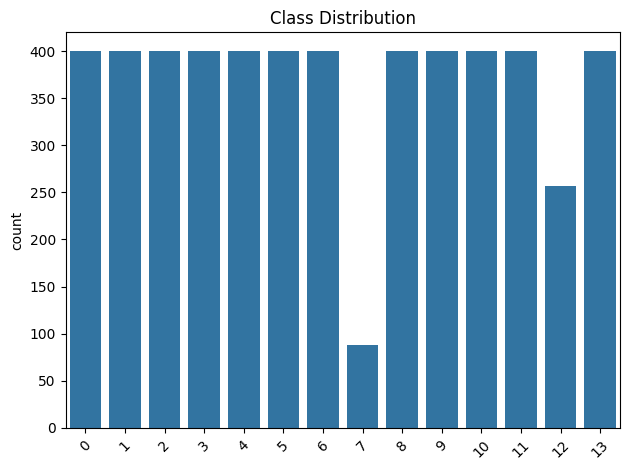

In [12]:
sns.countplot(x=y_train)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()

BALANCING

In [ ]:
X_train_balanced = []
y_train_balanced = []

for class_label in np.unique(y_train):
    X_class = X_train_pca[y_train == class_label]
    y_class = y_train[y_train == class_label]
    X_upsampled, y_upsampled = resample(
        X_class, y_class, replace=True,
        n_samples=max(np.bincount(y_train)),
        random_state=42
    )
    X_train_balanced.append(X_upsampled)
    y_train_balanced.append(y_upsampled)

X_train_balanced = np.vstack(X_train_balanced)
y_train_balanced = np.hstack(y_train_balanced)

encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train_balanced.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

Create & Visualize the QNN

In [ ]:
num_qubits = 6
feature_map = ZFeatureMap(num_qubits)
ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1)

circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

observables = []
for i in range(num_qubits):
    observables.append(SparsePauliOp.from_list([(f'I'*i + 'Z' + 'I'*(num_qubits - i - 1), 1.0)]))

observables += [
    SparsePauliOp.from_list([('ZZIIII', 1.0)]),
    SparsePauliOp.from_list([('IZIZII', 1.0)]),
    SparsePauliOp.from_list([('IIZIZI', 1.0)]),
    SparsePauliOp.from_list([('IIIZIZ', 1.0)]),
    SparsePauliOp.from_list([('ZIZIZI', 1.0)]),
    SparsePauliOp.from_list([('IZZZII', 1.0)]),
    SparsePauliOp.from_list([('IIZZIZ', 1.0)]),
    SparsePauliOp.from_list([('ZIIZZI', 1.0)]),
]

qnn = EstimatorQNN(
    circuit=circuit,
    observables=observables,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

initial_point = np.random.normal(0, 0.1, qnn.num_weights)

circuit.draw("mpl", style="clifford")

Objective function visualization

In [ ]:
objective_func_vals = []
all_weights = []

weight_names = [f"θ[{i}]" for i in range(len(initial_point))]

def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    all_weights.append(np.copy(weights))

    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(objective_func_vals, color='blue', label="Loss")
    axes[0].set_title("Loss vs Iteration")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    weights_array = np.array(all_weights)
    if weights_array.ndim == 2:
        for i in range(weights_array.shape[1]):
            axes[1].plot(weights_array[:, i], label=weight_names[i])
    axes[1].set_title("Weights vs Iteration")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Value")
    axes[1].legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

Train with SPSA optimizer

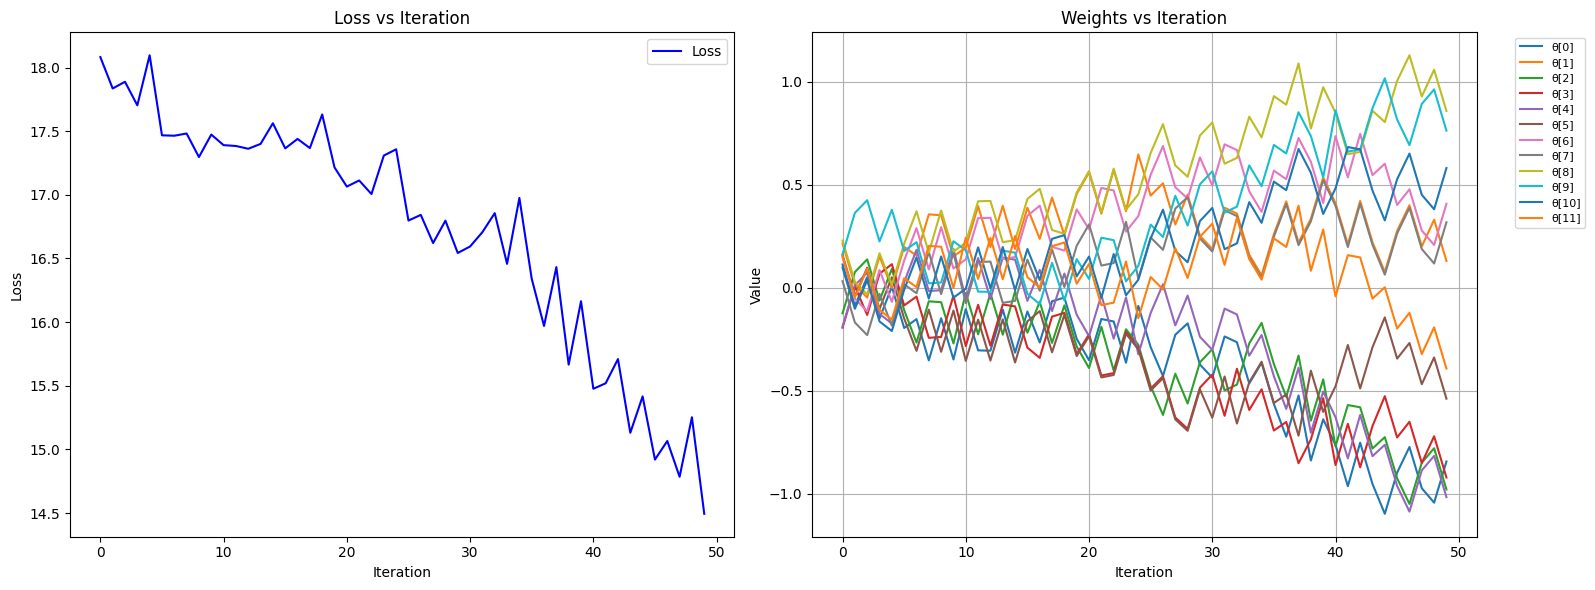

KeyboardInterrupt: 

In [ ]:

classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer = SPSA(maxiter=500, learning_rate=0.05, perturbation=0.1),
    loss='cross_entropy',
    one_hot=True,
    initial_point=initial_point,
    callback=callback_graph
)

classifier.fit(X_train_balanced, y_train_onehot)

In [ ]:
classifier.save('models/multiclass_NeuralNetworkClassifier_lung.model')

In [ ]:
train_accuracy = np.round(100 * classifier.score(X_train_balanced, y_train_onehot), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")

test_accuracy = np.round(100 * classifier.score(X_test_pca, y_test_onehot), 2)
print(f"Accuracy from the test data: {test_accuracy}%")

print("***************************************************")
predictions = classifier.predict(X_test_pca)
pred_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(pred_labels == true_labels)
print(f"Accuracy (based on predicted labels): {accuracy * 100:.2f}%")


Accuracy from the training data: 6.83%
***************************************************
Accuracy from the test data: 7.71%
***************************************************
Accuracy (based on predicted labels): 7.71%


In [ ]:
y_pred = classifier.predict(X_test_pca)

In [ ]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

classification_rep = metrics.classification_report(
    y_test_labels, y_pred_labels, output_dict=True, zero_division=True
)
conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
roc_auc = metrics.roc_auc_score(y_test_onehot, y_pred, multi_class='ovo')

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report: {'0': {'precision': 0.07262569832402235, 'recall': 0.24375, 'f1-score': 0.11190817790530846, 'support': 160.0}, '1': {'precision': 0.08645533141210375, 'recall': 0.1875, 'f1-score': 0.11834319526627218, 'support': 160.0}, '2': {'precision': 0.07397260273972603, 'recall': 0.16875, 'f1-score': 0.10285714285714286, 'support': 160.0}, '3': {'precision': 0.05917159763313609, 'recall': 0.07936507936507936, 'f1-score': 0.06779661016949153, 'support': 126.0}, '4': {'precision': 0.0873015873015873, 'recall': 0.275, 'f1-score': 0.13253012048192772, 'support': 160.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 160.0}, '6': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 146.0}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22.0}, '8': {'precision': 0.06666666666666667, 'recall': 0.00625, 'f1-score': 0.011428571428571429, 'support': 160.0}, '9': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 160.0}, '1

In [ ]:
y_pred_proba = classifier.predict_proba(X_test_pca)

Randomly select a class index from 0 to 13

In [ ]:
random_class_index = random.randint(0, 13)

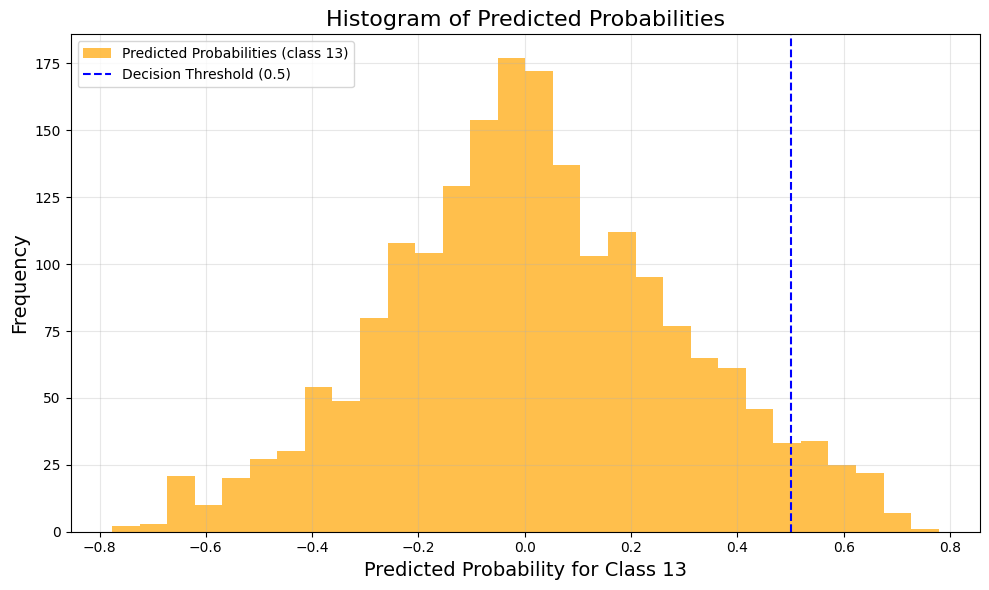

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(
    y_pred_proba[:, random_class_index],  # or another class index
    bins=30,
    alpha=0.7,
    color='orange',
    label=f'Predicted Probabilities (class {random_class_index})'
)
plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)
plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel(f'Predicted Probability for Class {random_class_index}', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Choose one class's probabilities for PCA visualization

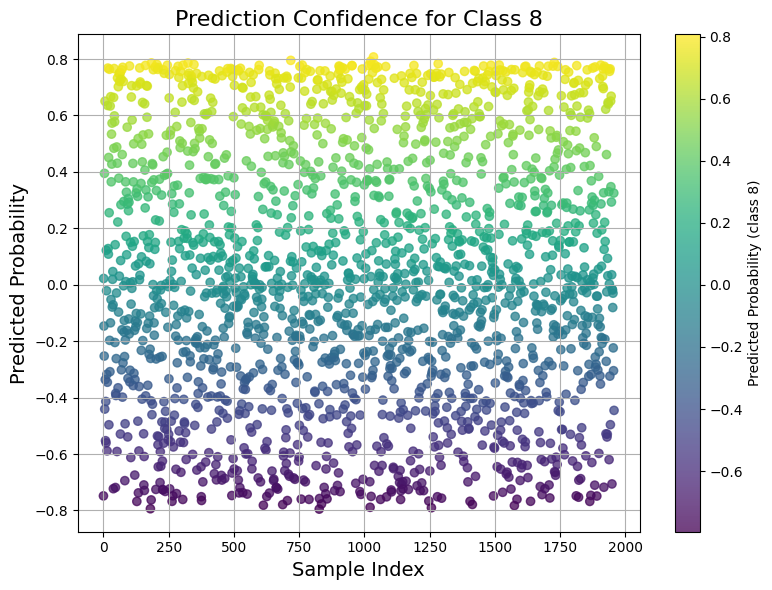

In [ ]:
random_class_index = random.randint(0, y_test_onehot.shape[1] - 1)
selected_class_probs = y_pred_proba[:, random_class_index]
sample_indices = np.arange(len(selected_class_probs))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    sample_indices,
    selected_class_probs,
    c=selected_class_probs,
    cmap='viridis',
    alpha=0.75
)

plt.colorbar(scatter, label=f'Predicted Probability (class {random_class_index})')
plt.title(f'Prediction Confidence for Class {random_class_index}', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


PCA Visualization of Predictions

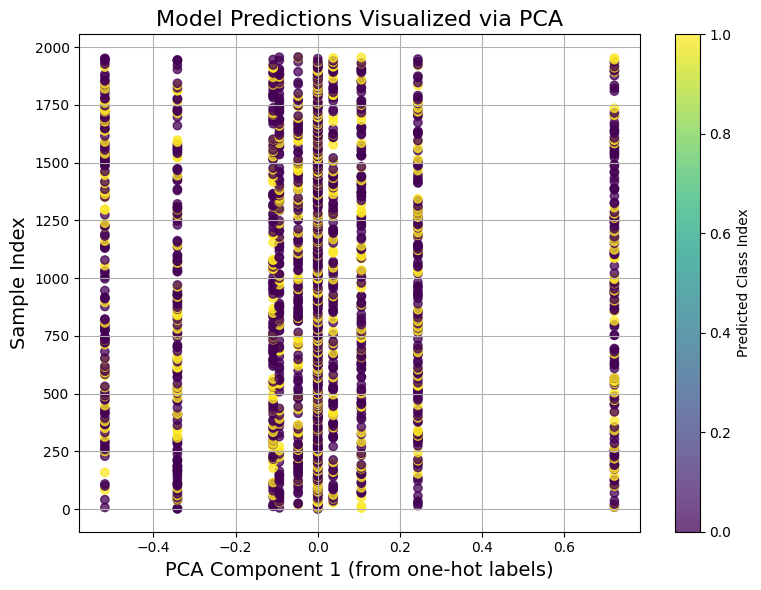

In [ ]:
y_pred = classifier.predict(X_test_pca)

if y_pred.ndim > 1:
    y_pred_selected = y_pred[:, 0]
else:
    y_pred_selected = y_pred

features_pca = PCA(n_components=1).fit_transform(y_test_onehot)

features_pca_flat = features_pca.flatten()

assert features_pca_flat.shape[0] == y_pred_selected.shape[0], "Shape mismatch!"

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_pca_flat,
    np.arange(len(features_pca_flat)),
    c=y_pred_selected,
    cmap='viridis',
    alpha=0.75
)

plt.colorbar(scatter, label='Predicted Class Index')
plt.title('Model Predictions Visualized via PCA', fontsize=16)
plt.xlabel('PCA Component 1 (from one-hot labels)', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()

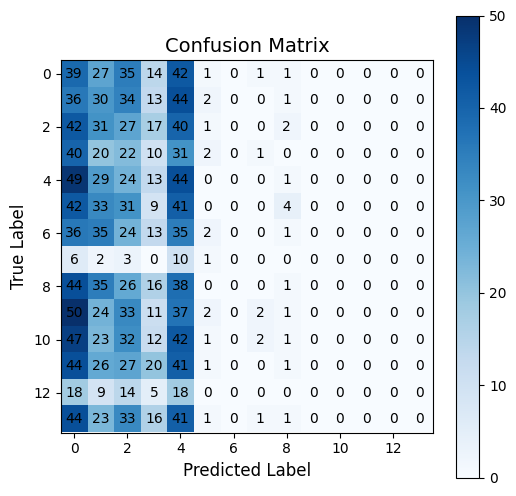

In [ ]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

In [ ]:
loaded_model = classifier.load('models/multiclass_NeuralNetworkClassifier_lung.model')

In [ ]:
subset_train_X = X_train_balanced[500:600]
subset_train_y = y_train_onehot[500:600]
train_score = loaded_model.score(subset_train_X, subset_train_y)

subset_test_X = X_test_pca[:10]
subset_test_y = y_test_onehot[:10]
test_score = loaded_model.score(subset_test_X, subset_test_y)

print(f"Quantum model accuracy on training subset (100 samples): {train_score * 100:.2f}%")
print(f"Quantum model accuracy on test subset (10 samples): {test_score * 100:.2f}%")

Quantum model accuracy on training subset (100 samples): 29.00%
Quantum model accuracy on test subset (10 samples): 0.00%


In [ ]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright